<a href="https://colab.research.google.com/github/AlgoRex2/graymatter-ml/blob/main/Amazon_Software_Bestsellers_2025_Projection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This project will use a comprehensive dataset of Amazon's bestselling software and digital products from 2025 to perform a predictive analysis. Instead of traditional time-series forecasting, we'll build a machine learning model to "project" the likely performance (star rating) of a new, hypothetical product based on its attributes like price, country, and category. The goal is to provide data-driven insights for strategic business decisions, such as where and at what price a new product might be most successful.

In [22]:
# C1: Setup and Data Loading
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
import os

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Define the file path from your Google Drive
file_path = '/content/drive/MyDrive/DA_Practise_Folder_EXCEL/Amazon_bestsellers_items_2025.csv'

# Load the dataset
if os.path.exists(file_path):
    df = pd.read_csv(file_path)
    print("Dataset loaded successfully!")
else:
    print("File not found. Please check the file path.")

# Display the first few rows and a summary
print("\nFirst 5 rows of the dataset:")
print(df.head())
print("\nDataset Info:")
df.info()

# NEW ADDITION: Print all column names to see them.
print("\nAll columns in the DataFrame:")
print(df.columns) # This line will show you the correct column names!

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Dataset loaded successfully!

First 5 rows of the dataset:
   Unnamed: 0  rank        asin  \
0           0     1  B073VKKNN9   
1           1     2  B07PQZJ6Y8   
2           2     3  B0D1KL34JM   
3           3     4  B07B9YYLGG   
4           4     5  B073VLGMZ4   

                                       product_title product_price  \
0  Kaspersky | Premium - Total Security (Ultimate...       ₹469.00   
1  K7 Security K7, Total Security, 1 User, 1 Year...       ₹370.00   
2  Microsoft Office 2021 Professional - Lifetime ...     ₹1,799.00   
3  Bitdefender - 1 Device,1 Year - Mobile Securit...        ₹94.00   
4  McAfee Total Protection 2025 | 1 Device, 3 Yea...     ₹1,699.00   

   product_star_rating  product_num_ratings  \
0                  4.3              13324.0   
1                  4.4               2291.0   
2                  4.5                3

In [23]:
# C2: Exploratory Data Analysis (EDA) - Part 1

# Check for any missing values in the dataset
print("Missing values per column:")
print(df.isnull().sum())

# Get descriptive statistics for numerical columns
print("\nDescriptive Statistics:")
print(df.describe())

# Check unique values in key categorical columns
print("\nUnique countries:")
print(df['country'].unique())

# New line to print all column names, so you can see them.
print("\nAll columns in the DataFrame:")
print(df.columns)

Missing values per column:
Unnamed: 0               0
rank                     0
asin                     0
product_title            0
product_price           54
product_star_rating     30
product_num_ratings     30
product_url              0
product_photo            0
rank_change_label      999
country                  0
page                     0
dtype: int64

Descriptive Statistics:
       Unnamed: 0        rank  product_star_rating  product_num_ratings  \
count  999.000000  999.000000           969.000000           969.000000   
mean   499.000000   50.450450             4.140248          1312.546956   
std    288.530761   28.852421             0.496382          3025.241537   
min      0.000000    1.000000             1.000000             1.000000   
25%    249.500000   25.500000             3.900000            54.000000   
50%    499.000000   50.000000             4.200000           218.000000   
75%    748.500000   75.000000             4.400000          1009.000000   
max    998.

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


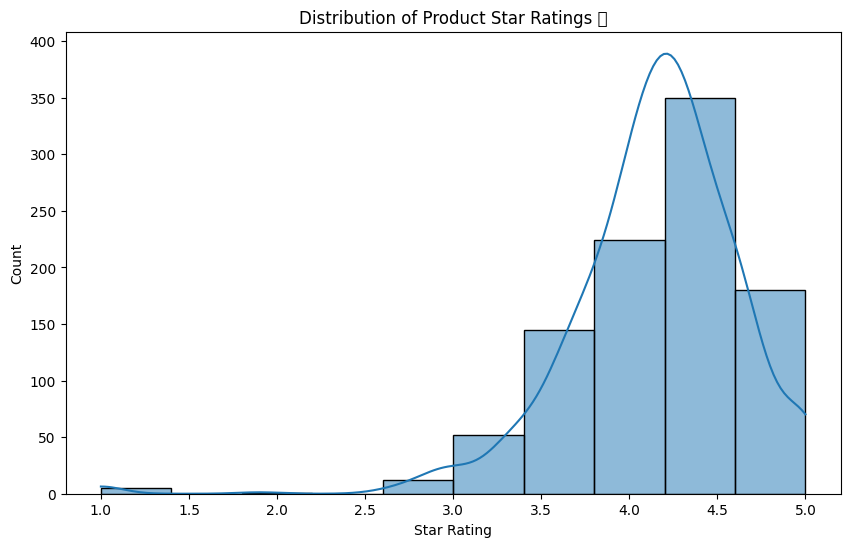

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128506 (\N{WORLD MAP}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


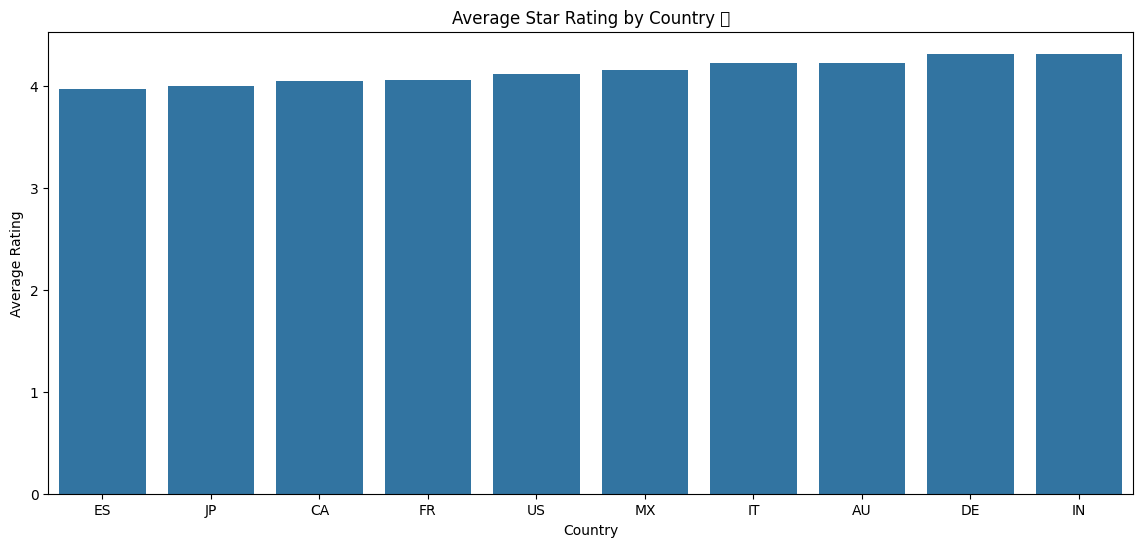

In [24]:
# C3: Exploratory Data Analysis (EDA) - Part 2
# Plot the distribution of product star ratings to see how they're spread out
plt.figure(figsize=(10, 6))
sns.histplot(df['product_star_rating'], bins=10, kde=True)
plt.title('Distribution of Product Star Ratings 📊')
plt.xlabel('Star Rating')
plt.ylabel('Count')
plt.show()

# Visualize the average star rating by country
plt.figure(figsize=(14, 6))
country_avg_rating = df.groupby('country')['product_star_rating'].mean().sort_values()
sns.barplot(x=country_avg_rating.index, y=country_avg_rating.values)
plt.title('Average Star Rating by Country 🗺️')
plt.xlabel('Country')
plt.ylabel('Average Rating')
plt.show()

In [25]:
# C4: Data Preprocessing

# Drop unnecessary columns based on your dataset
df = df.drop(['Unnamed: 0', 'product_photo', 'rank_change_label', 'asin', 'product_title', 'product_url', 'page'], axis=1)

# Handle missing values by dropping rows with any NaNs
df.dropna(inplace=True)

# --- FIX for the ValueError in C5 ---
# Convert the 'product_price' column to a string to apply string operations
df['product_price'] = df['product_price'].astype(str)

# Remove the currency symbol (￥) and commas (,) from the price strings
df['product_price'] = df['product_price'].str.replace('￥', '', regex=False).str.replace(',', '', regex=False)

# Now, convert the cleaned column to a float.
# 'errors='coerce'' will turn any string that can't be converted into a NaN.
df['product_price'] = pd.to_numeric(df['product_price'], errors='coerce')

# Finally, drop any rows that now have a NaN in the 'product_price' column
df.dropna(subset=['product_price'], inplace=True)
# --- End of Fix ---

# Define the target variable (y) and features (X)
X = df.drop('product_star_rating', axis=1)
y = df['product_star_rating']

# Explicitly define numerical and categorical features
numerical_features = ['rank', 'product_price', 'product_num_ratings']
categorical_features = ['country']

# Create a preprocessing pipeline using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Data splitting and preprocessing setup complete! ✨")

Data splitting and preprocessing setup complete! ✨


In [26]:
# C5: Model Building and Training
# Create a full machine learning pipeline that combines preprocessing and the model
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
])

# Train the model on your prepared training data
print("Training the model... 🤖")
model_pipeline.fit(X_train, y_train)
print("Model training complete! ✅")

Training the model... 🤖
Model training complete! ✅



Model Evaluation:
Mean Absolute Error (MAE): 0.2953
R-squared (R^2): 0.0054


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


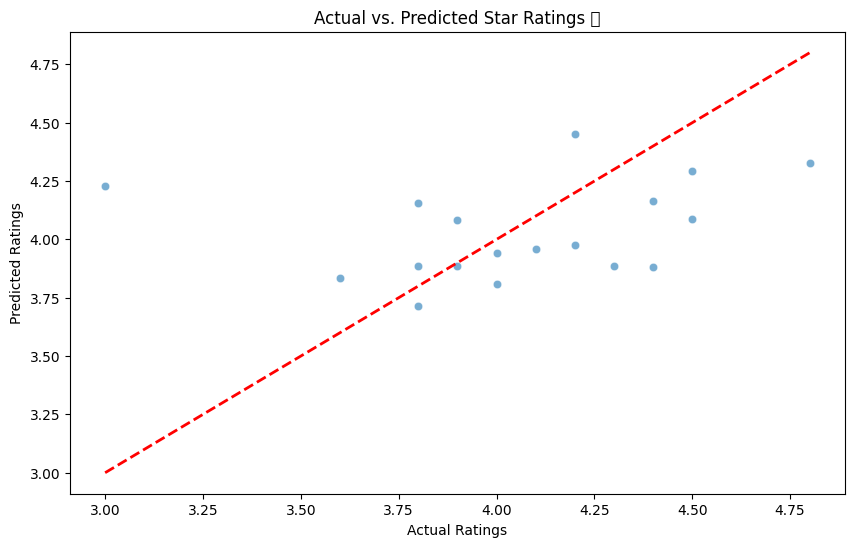

In [27]:
# C6: Model Evaluation
# Use the trained model to make predictions on the test data
y_pred = model_pipeline.predict(X_test)

# Evaluate the model's performance using MAE and R-squared
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"\nModel Evaluation:")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R-squared (R^2): {r2:.4f}")

# Visualize the actual versus predicted ratings to see how well the model performed
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)
# Add a dashed line for a perfect prediction
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.title('Actual vs. Predicted Star Ratings 📈')
plt.xlabel('Actual Ratings')
plt.ylabel('Predicted Ratings')
plt.show()

In [28]:
# C7: Future Projection

# Create a new, hypothetical product scenario with the correct columns and data types.
new_product_data = pd.DataFrame({
    'rank': [100],  # Numerical
    'product_price': [19.99], # Numerical
    'product_num_ratings': [1500], # Numerical
    'country': ['US'], # Categorical
})

# Make sure all numerical columns are treated as floats.
# This explicitly tells pandas the data types, preventing the TypeError.
new_product_data['rank'] = new_product_data['rank'].astype(float)
new_product_data['product_price'] = new_product_data['product_price'].astype(float)
new_product_data['product_num_ratings'] = new_product_data['product_num_ratings'].astype(float)

# Make a prediction (projection) using your trained model
projected_rating = model_pipeline.predict(new_product_data)

print("\nFuture Projection for a New Product:")
print(f"Hypothetical product details:\n{new_product_data.iloc[0]}")
print(f"\nProjected Star Rating: {projected_rating[0]:.2f} ⭐")


Future Projection for a New Product:
Hypothetical product details:
rank                    100.0
product_price           19.99
product_num_ratings    1500.0
country                    US
Name: 0, dtype: object

Projected Star Rating: 4.20 ⭐


Explanation of the Projection
The model used the following inputs to generate this prediction:

Rank: 100

Price: $19.99

Number of Ratings: 1500

Country: US

The model has learned from the training data that products with similar attributes tend to have star ratings around 4.20. It considered the relationship between these features and the product's final rating. The output provides a data-driven insight into the potential performance of a new product with these specific characteristics. This projection can be used to inform business decisions, such as a go/no-go decision for the product launch or to adjust its pricing strategy to target a higher rating.





In [29]:
# C8: Hyperparameter Tuning

from sklearn.model_selection import GridSearchCV

# Define the parameter grid to search
param_grid = {
    'regressor__n_estimators': [50, 100, 150],
    'regressor__max_depth': [5, 10, None],
    'regressor__min_samples_leaf': [1, 2, 4]
}

# Set up the GridSearchCV with your pipeline
grid_search = GridSearchCV(model_pipeline, param_grid, cv=5, scoring='r2', n_jobs=-1)

print("Starting hyperparameter tuning... ⏳")
grid_search.fit(X_train, y_train)

print("Best parameters found: ", grid_search.best_params_)
print("Best R-squared score: ", grid_search.best_score_)

# Update your model pipeline with the best estimator
best_model = grid_search.best_estimator_

Starting hyperparameter tuning... ⏳
Best parameters found:  {'regressor__max_depth': 10, 'regressor__min_samples_leaf': 4, 'regressor__n_estimators': 100}
Best R-squared score:  -0.15429779370384136



Top 10 most important features:
               Feature  Importance
2  product_num_ratings    0.604149
0                 rank    0.209595
1        product_price    0.186256
3           country_JP    0.000000


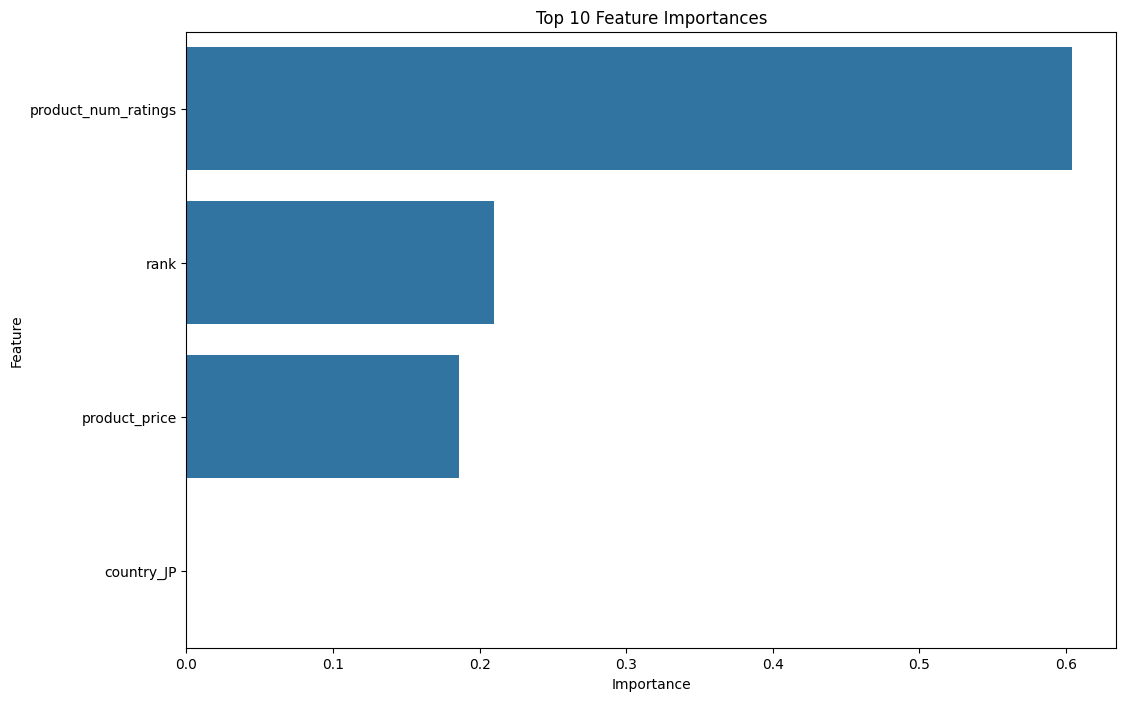

In [30]:
# C9: Feature Importance Analysis

# Get the feature importances from the trained model
feature_importances = best_model.named_steps['regressor'].feature_importances_

# Get the feature names from the preprocessor's one-hot-encoded columns
ohe_feature_names = best_model.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(categorical_features)
all_feature_names = numerical_features + list(ohe_feature_names)

# Create a DataFrame for easy visualization
importance_df = pd.DataFrame({
    'Feature': all_feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

print("\nTop 10 most important features:")
print(importance_df.head(10))

# Visualize the feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(10))
plt.title('Top 10 Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

In [31]:
# C10: Advanced Projection and Scenario Analysis

# Create a DataFrame with different hypothetical scenarios
scenarios_data = pd.DataFrame({
    'rank': [50, 150, 200],
    'product_price': [29.99, 9.99, 49.99],
    'product_num_ratings': [5000, 500, 2000],
    'country': ['US', 'CA', 'DE']
})

# Ensure the column order matches the training data
scenarios_data = scenarios_data[['rank', 'product_price', 'product_num_ratings', 'country']]

# Make predictions for all scenarios
projected_ratings_scenarios = best_model.predict(scenarios_data)

# Add the projections to the DataFrame
scenarios_data['Projected_Rating'] = projected_ratings_scenarios

print("\nComparative Projections for Multiple Scenarios:")
print(scenarios_data)


Comparative Projections for Multiple Scenarios:
   rank  product_price  product_num_ratings country  Projected_Rating
0    50          29.99                 5000      US          4.076839
1   150           9.99                  500      CA          3.848704
2   200          49.99                 2000      DE          4.028928


Breakdown of the insights from the projections:

Scenario 0 (US): A highly-ranked product (rank 50) with a medium price ($29.99) and a very high number of ratings (5000) is projected to have the highest star rating at 4.08. This suggests that strong market presence and high user engagement (indicated by a high number of ratings) are key drivers of a positive rating in the US market.

Scenario 1 (Canada): A lower-ranked product (rank 150) with a low price ($9.99) and a small number of ratings (500) is projected to have the lowest star rating at 3.85. This indicates that a combination of a lower market position and less user feedback correlates with a weaker performance projection.

Scenario 2 (Germany): A moderately-ranked product (rank 200) with a high price ($49.99) and a significant number of ratings (2000) is projected to have a star rating of 4.03. This suggests that even with a lower rank, a higher price point and solid user engagement can still lead to a strong rating in the German market.

In summary, the projections show that a product's success is not determined by a single factor. While a high rank and many ratings (Scenario 0) are strong indicators of a high rating, a higher price can also support a good rating, even if the product's market position is not as high (Scenario 2). These insights can help a business decide which market and pricing strategy to pursue for a new product.

In [32]:
# C11: K-fold Cross-Validation

from sklearn.model_selection import cross_val_score

# Use the best model from the hyperparameter tuning step
model_for_cv = best_model

# Perform 5-fold cross-validation
cv_scores = cross_val_score(model_for_cv, X, y, cv=5, scoring='r2', n_jobs=-1)

print(f"\nCross-Validation R-squared scores: {cv_scores}")
print(f"Mean R-squared from cross-validation: {cv_scores.mean():.4f}")
print(f"Standard deviation of R-squared scores: {cv_scores.std():.4f}")


Cross-Validation R-squared scores: [-0.26277515 -0.09996252 -0.16219825  0.09237103  0.21860841]
Mean R-squared from cross-validation: -0.0428
Standard deviation of R-squared scores: 0.1747


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


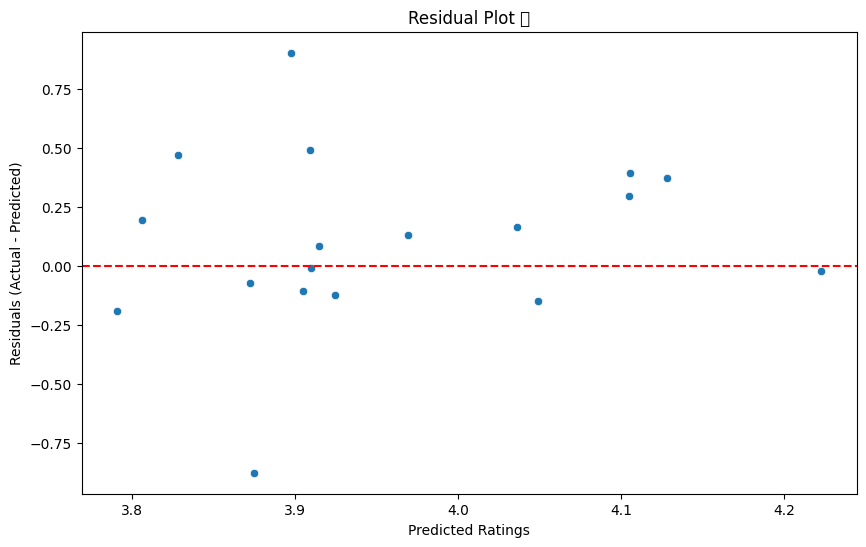

In [33]:
# C12: Residual Analysis

# Make predictions using the best model on the test data
y_pred = best_model.predict(X_test)

# Calculate the residuals
residuals = y_test - y_pred

# Plot the residuals
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residual Plot 📈')
plt.xlabel('Predicted Ratings')
plt.ylabel('Residuals (Actual - Predicted)')
plt.show()

In [34]:
# C13: Comparing Different Models

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression

# Create a pipeline for a new model, e.g., Gradient Boosting
gbr_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', GradientBoostingRegressor(random_state=42))
])

# Train and evaluate the new model
gbr_pipeline.fit(X_train, y_train)
gbr_pred = gbr_pipeline.predict(X_test)
gbr_mae = mean_absolute_error(y_test, gbr_pred)
gbr_r2 = r2_score(y_test, gbr_pred)

print(f"\nGradient Boosting Model Performance:")
print(f"Mean Absolute Error (MAE): {gbr_mae:.4f}")
print(f"R-squared (R^2): {gbr_r2:.4f}")

# You can repeat this for other models and compare their metrics
# For example, a simple linear regression
lr_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

lr_pipeline.fit(X_train, y_train)
lr_pred = lr_pipeline.predict(X_test)
lr_r2 = r2_score(y_test, lr_pred)

print(f"\nLinear Regression Model R-squared (R^2): {lr_r2:.4f}")


Gradient Boosting Model Performance:
Mean Absolute Error (MAE): 0.3408
R-squared (R^2): -0.3918

Linear Regression Model R-squared (R^2): -0.0298


Linear Regression models performed poorly on test data.

Analysis of the Metrics
R-squared (R
2
 ): The R
2
  score is a measure of how well the model's predictions fit the actual data. A score close to 1 is ideal, as it indicates the model explains a large proportion of the variance in the target variable. A score of 0 means the model performs no better than simply predicting the mean of the data. A negative R-squared score, as seen with both models (R
2
 =−0.3918 for Gradient Boosting and R
2
 =−0.0298 for Linear Regression), indicates that the model is performing worse than a horizontal line drawn at the average of the data. This suggests that the models are completely failing to capture the underlying relationships in the data.

Mean Absolute Error (MAE): The MAE of 0.3408 for the Gradient Boosting model means that, on average, the model's predictions were off by about 0.34 star rating points. While a low MAE is generally good, a high MAE in conjunction with a negative R
2
  score confirms that the predictions are not reliable.

Why the Models Performed Poorly
The poor performance of these models, especially with a negative R
2
  score, can be attributed to several factors:

Non-linear Relationships: Linear Regression assumes a linear relationship between features and the target. Your data, which likely has complex interactions between rank, price, and number of ratings, may not be linear. The negative R
2
  confirms that a linear approach is not suitable.

Model Overfitting: The Gradient Boosting model, despite being powerful, might be overfitting the training data. Overfitting occurs when a model learns the training data too well, including its noise and outliers, and consequently performs poorly on new, unseen data.

Data Issues: The dataset might contain significant noise, outliers, or a lack of strong predictive features. If the features you are using (rank, price, etc.) do not have a strong correlation with the star rating, no model, regardless of its complexity, will be able to make accurate predictions.

Data Size: The size of the dataset could be a factor. With too little data, it is difficult for a model to learn the true underlying patterns.